#TIME SERIES ANALYSIS

#Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

##DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy. 

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [2]:
from IPython.display import Image
Image(url = "https://raw.githubusercontent.com/fedhere/PUI2015_fbianco/master/HW6/Ridetypes.png")

In [4]:
from __future__ import print_function
import pylab as pl
import numpy as np
import pandas as pd
import json
import os
import matplotlib.gridspec as gridspec
from tabulate import tabulate
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
%pylab inline 

# s = json.load(open(os.getenv('PUI2015')+'/fbb_matplotlibrc.json'));
s = json.load(open('../fbb_matplotlibrc.json'));
pl.rcParams.update(s)

Populating the interactive namespace from numpy and matplotlib


In [5]:
mta = np.load('MTA_Fare.npy')

In [6]:
#Settin -1 to nan
mta = np.where(mta !=-1, mta, np.nan)

In [7]:
ridetypes = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [8]:
mta_station_sum = np.nansum(mta, axis=1)
mta_ridetype_sum = np.nansum(mta, axis=0)

In [9]:
print(mta_station_sum.shape)
print(mta_ridetype_sum.shape)

(600L, 194L)
(23L, 194L)


In [10]:
mta_ridetype_sum = pd.DataFrame(np.transpose(mta_ridetype_sum))
mta_station_sum = pd.DataFrame(np.transpose(mta_station_sum))

In [11]:
dateRange = pd.date_range(pd.to_datetime('05/21/2010'), 
                                        pd.to_datetime('02/07/2014'),
                                        freq='W')
mta_ridetype_sum.index = pd.Index(dateRange)
mta_station_sum.index = pd.Index(dateRange)

In [13]:
mta_ridetype_sum.rename(columns=lambda x: ridetypes[x], inplace=True)
mta_ridetype_sum.head()

10t     14d     1d      2t    30d       7d      ada   afas  \
2010-05-23  11494615  530524  47801  186551  46808  3697443  8551937  10063   
2010-05-30  12526859  583533  51486  199229  64353  3981808  9486394  11847   
2010-06-06  12766627  586194  51636  199668  56994  4033030  9476538  12277   
2010-06-13  12653675  562602  52063  196389  37429  4032753  9450081  11221   
2010-06-20  12809694  548858  51153  194883  35210  3925446  9294002  10515   

               exp      ez  ...    month     rfm     rr    sen  spec    tcmc  \
2010-05-23  333197  512032  ...   123134  790110  59809  28221     0  124693   
2010-05-30  282755  578023  ...   151948  908068  69209  32333     0  121713   
2010-06-06  302028  615537  ...   151538  914124  69574  32618     0  122181   
2010-06-13  305513  606270  ...   147094  902549  68099  32404     0  122051   
2010-06-20  335780  563446  ...   137888  855573  66377  31933   176  119776   

                t  umlim  xbus  stud  
2010-05-23  21060   6128   358     0  
2010-05-30  21670   6120   474     0  
2010-06-06  21433   6490   465     0  
2010-06-13  21630   6590   484     0  
2010-06-20  20297   6313   452     0  

[5 rows x 23 columns]

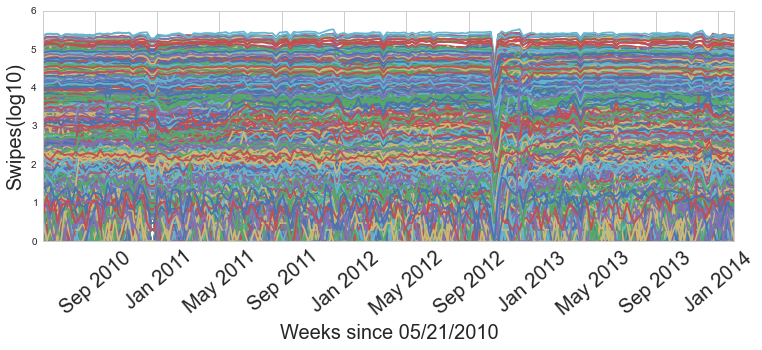

In [41]:
fig = figure(figsize=(12,4))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xlabel('Weeks since 05/21/2010', size=25)
ax.set_ylabel('Swipes(log10)', size=20)
ax.tick_params(axis='x',labelsize=10)
pl.xticks(rotation=45, fontsize=20)
for st in range(mta.shape[0]):
    for rt in range(mta.shape[1]):
        ax.plot(dateRange, np.log10(mta[st,rt]))

#Task 1: 
##Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
##Identify it and figure out what it is due to.

In [84]:
mta_weekly_avg= mta_ridetype_sum.mean(axis=1)
thresholds = [mta_weekly_avg.mean() + 3*mta_weekly_avg.std(), 
              mta_weekly_avg.mean() - 3*mta_weekly_avg.std()]
print (thresholds)

[1685060.5467554727, 904622.0507344422]


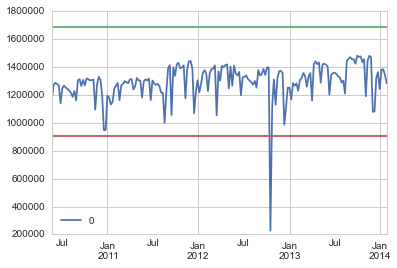

In [87]:
ax = mta_weekly_avg.plot()
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[0], thresholds[0]])
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]])

In [86]:
mta_weekly_avg = pd.DataFrame(mta_weekly_avg)

0
2012-10-21  226899.391304

## Event that sudden drop in timeseries is on Oct 21, 2012 which is caused by Hurricane Sandy (October 22, 2012 to October 31, 2012.)

# Task 2


In [117]:
fluxRatios = mta_ridetype_sum.head(10).mean()/mta_ridetype_sum.tail(10).mean()
stds = mta_ridetype_sum.std()

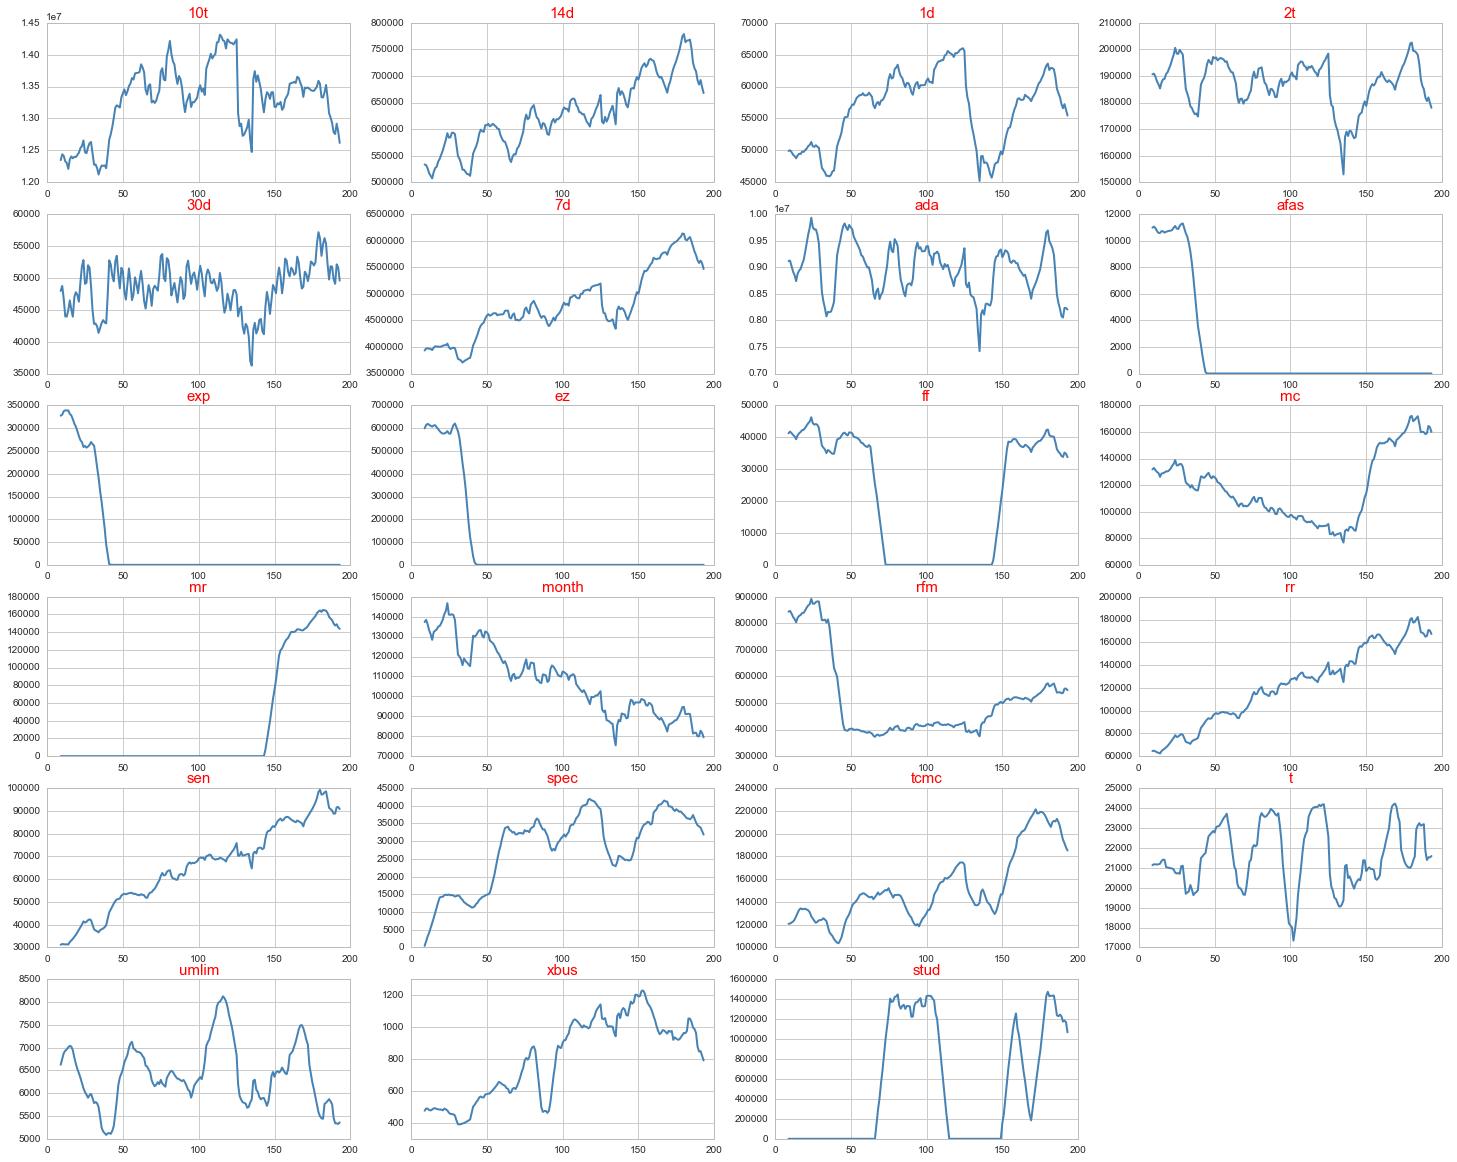

In [121]:
fig = pl.figure(figsize=(25,20))

for ri in range(0,23):
    ax = fig.add_subplot(6,4,ri+1)
    ax.plot(pd.rolling_mean(mta_ridetype_sum[ridetype[ri]], window =10))
    ax.set_title(ridetypes[ri], fontsize=15, color='r')

# Comments 
* the steepest increase in ridetype 14d, 7d, ff, sen
* the steepest decrease in ridetype month

### We Can see sudden drop to 0 from Fluxratio

* the steepest decrease and sudden drop to 0 in ridetype afas, exp, ez -> Fluxration is realy high

In [119]:
table = pd.DataFrame({'RideType' : fluxRatios.index,
                     'Flux Ratio From Beginning to End' : fluxRatios.values,
                     'Std' : stds.values})
print( tabulate(table, headers='keys', tablefmt="grid", floatfmt='.4f') )

+---------+------------------------------------+--------------+--------+
|         |   Flux Ratio From Beginning to End |          Std | Type   |
+=========+====================================+==============+========+
|  0.0000 |                             0.9787 | 1215646.4611 | 10t    |
+---------+------------------------------------+--------------+--------+
|  1.0000 |                             0.7987 |   90866.0875 | 14d    |
+---------+------------------------------------+--------------+--------+
|  2.0000 |                             0.8998 |    7618.8891 | 1d     |
+---------+------------------------------------+--------------+--------+
|  3.0000 |                             1.0709 |   17636.1043 | 2t     |
+---------+------------------------------------+--------------+--------+
|  4.0000 |                             0.9673 |   12666.5250 | 30d    |
+---------+------------------------------------+--------------+--------+
|  5.0000 |                             0.7196 |  7

#Task 3

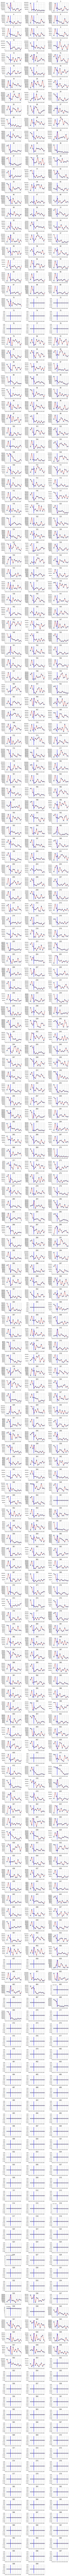

In [31]:
fig = plt.figure(figsize=(10,400))

for i in range(1, 600):
    ax = fig.add_subplot(200,3,i)
    f = np.abs(np.fft.rfft(mta_station_sum[i-1]))
    ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], 'o', ms=8)
    ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], '-')
    pl.subplots_adjust(wspace=.5, hspace=.5, left=.125, right=.9, bottom=.1)
    ax.set_xlim(0,1.0/15)
    plt.axvline(1.0/52)
    ax.set_title(i)

# Stations 1, 151, 195, 328 show a prominent annual periodicity by looking at the graph